In [23]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import warnings
import neptune
# import networkx as nx


%load_ext autoreload
%autoreload 2

from src.features import *
from src.utils import *
from src.models import *
from src.optimizers import *
from src.loss_functions import *
from src.dataloaders import *
from src.security import NEPTUNE_TOKEN
from src.pipeline_functions import *

plt.style.use("ggplot")
# show all columns
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 45
set_seed(SEED)

In [3]:
stocks = ["SPY", "VTV", "VUG", "VYM", "QQQ", "VNQ", "GLD", "AGG", "SOXX", "OIH", "IYT", "XLF", "XLV", "VOX", "XLY", "XLP", "BND", "BSV", "IEMG", "VEA", "VWO"]
stocks = sorted(stocks)

stock_classes = {'AGG': 'EQUITY', 'GLD': 'COMMODITY', 'IYT': 'EQUITY', 'OIH': 'EQUITY', 'QQQ': 'EQUITY',
                 'SOXX': 'EQUITY', 'SPY': 'EQUITY', 'VNQ': 'REAL_ESTATE', 'VOX': 'EQUITY', 'VTV': 'EQUITY',
                 'VUG': 'EQUITY', 'VYM': 'EQUITY', 'XLF': 'EQUITY', 'XLP': 'EQUITY', 'XLV': 'EQUITY', 'XLY': 'EQUITY',
                 "BND": "FIXED_INCOME", "BSV": "FIXED_INCOME", "IEMG": "EQUITY", "VEA": "EQUITY", "VWO": "EQUITY"
}

classes_color = {'EQUITY': 'salmon', 'COMMODITY': 'cyan', 'FIXED_INCOME': 'lightgreen', "REAL_ESTATE": "lightblue"}

len(stocks)

21

In [4]:
path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = get_data(path, stocks)

AGG Start of history: 2003-09-29
BND Start of history: 2007-04-10
BSV Start of history: 2007-04-10
GLD Start of history: 2004-11-18
IEMG Start of history: 2012-10-24
IYT Start of history: 2004-01-02
OIH Start of history: 2001-02-26
QQQ Start of history: 1999-03-10
SOXX Start of history: 2001-07-13
SPY Start of history: 1993-01-29
VEA Start of history: 2007-07-26
VNQ Start of history: 2004-09-29
VOX Start of history: 2004-09-29
VTV Start of history: 2004-01-30
VUG Start of history: 2004-01-30
VWO Start of history: 2005-03-10
VYM Start of history: 2006-11-16
XLF Start of history: 1998-12-22
XLP Start of history: 1998-12-22
XLV Start of history: 1998-12-22
XLY Start of history: 1998-12-22


In [5]:
nodes_matrix, combined_adj_matrix, cov_adj_matrix, future_return, df_return, df_features = features_pipeline(df_adj_close, df_close, df_high, df_low, df_volume, stocks=stocks)

Features generated and scaled
Return features generated
Correlation and covariance matrices generated
Common index length 2416


100%|██████████| 2416/2416 [05:03<00:00,  7.95it/s]

Adjacency matrices generated
Pipeline finished


In [6]:
TRAIN = 1800
PERIOD = 90 #max window for features' calculation

train_dataset = Dataset(nodes_matrix[:TRAIN], 
                          combined_adj_matrix[:TRAIN], 
                          cov_adj_matrix[:TRAIN], 
                          future_return[:TRAIN])

test_dataset = Dataset(nodes_matrix[TRAIN+PERIOD:],
                            combined_adj_matrix[TRAIN+PERIOD:],
                            cov_adj_matrix[TRAIN+PERIOD:],
                            future_return[TRAIN+PERIOD:])

len(test_dataset)

526

### Maximize Sharpe Ratio

In [20]:
model = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=10, pred_window=5, n_heads=2)
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [21]:
count_parameters(model)

+----------------------------------+------------+
|             Modules              | Parameters |
+----------------------------------+------------+
|              gamma               |     1      |
|        pred_layer.rgat1.q        |     60     |
|        pred_layer.rgat1.k        |     60     |
|      pred_layer.rgat1.bias       |     30     |
|        pred_layer.rgat1.e        |     60     |
|     pred_layer.rgat1.weight      |    3450    |
|        pred_layer.rgat1.w        |     15     |
|       pred_layer.rgat1.l1        |     15     |
|       pred_layer.rgat1.b1        |     15     |
|       pred_layer.rgat1.l2        |    225     |
|       pred_layer.rgat1.b2        |     15     |
| pred_layer.rgat1.lin_edge.weight |     30     |
|        pred_layer.rgat2.q        |     40     |
|        pred_layer.rgat2.k        |     40     |
|      pred_layer.rgat2.bias       |     10     |
|        pred_layer.rgat2.e        |     40     |
|     pred_layer.rgat2.weight      |    3000    |


7357

In [24]:
loss_list, gamma_list = train(model, optim, train_dataset, epochs=4,
                              eval_func='sharpe_loss', exp_name='GrossModel_v1_sharpe_21205', neptune_token=NEPTUNE_TOKEN,
                                neptune_project="aibabynin/graphs")

https://app.neptune.ai/aibabynin/graphs/e/GRAP-12
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-12/metadata


In [25]:
test_weights_matrix = evaluate(model, test_dataset)

100%|██████████| 511/511 [00:28<00:00, 17.95it/s]


In [26]:
ret = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].index

In [27]:
p_ret = (ret * test_weights_matrix).sum(1)

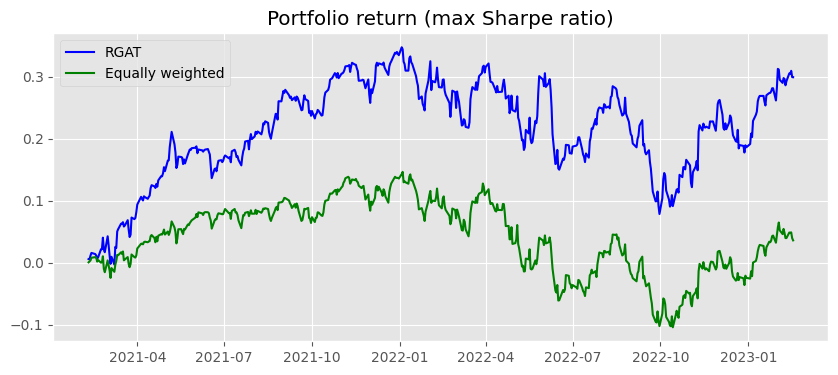

In [28]:
plt.figure(figsize=(10, 4))
_ = plt.plot(index, (p_ret+1).cumprod()-1, color='blue', label='RGAT')
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted')
plt.title('Portfolio return (max Sharpe ratio)')
plt.legend()
plt.show()

### Maximize return

In [29]:
model2 = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=10, pred_window=5, n_heads=2)
optim2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.0001)

In [30]:
loss_list2, gamma_list2 = train(model2, optim2, train_dataset, epochs=4,
                              eval_func='max_return', exp_name='GrossModel_v1_max_return_2205', neptune_token=NEPTUNE_TOKEN,
                                neptune_project="aibabynin/graphs")

https://app.neptune.ai/aibabynin/graphs/e/GRAP-13
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-13/metadata


In [31]:
test_weights_matrix2 = evaluate(model2, test_dataset)

100%|██████████| 511/511 [00:39<00:00, 12.85it/s]


In [32]:
p_ret2 = (ret * test_weights_matrix2).sum(1)

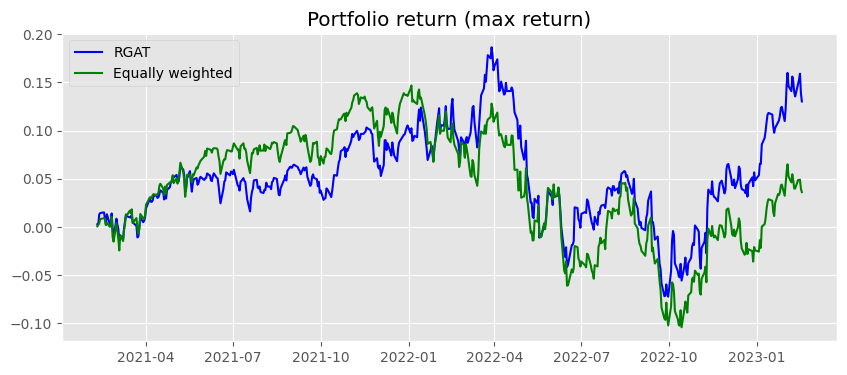

In [33]:
plt.figure(figsize=(10, 4))
_ = plt.plot(index, (p_ret2+1).cumprod()-1, color='blue', label='RGAT')
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted')
plt.title('Portfolio return (max return)')
plt.legend()
plt.show()